# 回帰のサンプル
計測を仕事にしてる人向けの雑なstanの使い方の例

回帰の組み方の例と、弱事前分布は「高々これぐらい」という感じで気軽に使おうという話の説明用。

解説記事は別途作成中


In [1]:
#Uncomennt to install the library  on jupyter lab (Unix etc..)
#!pip install mako
#!pip install pystan
#!pip install arviz

#windowsで試すひとはAnaconda/JupyterLabをインストールして以下のようにライブラリを追加
#On windows Anaconda
#Run following in conda terminal on windows
#conda install mako pystan arviz
#conda install libpython m2w64-toolchain -c msys2


from stan_util import get_stan_model,print_code
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

#回帰の結果をプロットする関数（中身は気にしなくて良い）
def plot_rec(X,Y,fit,NOF_PLOT=200):
    yy=fit.extract("yy")["yy"]
    skip=yy.shape[0]//NOF_PLOT
    if(skip<1):skip=1
    plt.title("Regression lines")
    plt.plot(X,yy[::skip,:].transpose(),color="blue",alpha=0.1)
    plt.plot(X,Y,color="red")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
    plt.title("Residue of Y")
    plt.xlabel("X")
    plt.ylabel("Y-yy")
    plt.plot(X,yy[::skip,:].transpose()-Y.reshape(-1,1),color="blue",alpha=0.1)
    plt.show()

# 一定値の計測
重量計のように、一定回数計測して平均値を取る場合を想定しています。
シミュレーションデータは平均mu=0、それにガウスノイズsigma=1がのっています。


1つ目は事前情報なし（十分に広い一様分布）、２つめは広いガウス分布が事前分布（弱事前分布）

広いガウス分布程度なら影響推定結果には「ほぼ影響ない」ってのがここで重要なポイント。
計算を安定させるためだけの、弱事前分布の設定ってのはよくやります。



## 事前分布なし（一様）

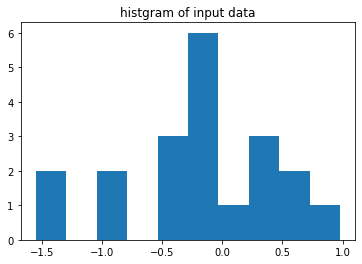

========1st: Without prior
1 
2 data{
3     int N;
4     vector[N] Y;
5 
6 
7 }
8 
9 parameters{
10     real mu;
11     real<lower=0> sigma;
12 }
13 model{
14     Y ~ normal(mu,sigma);
15 }
16 
Inference for Stan model: static_6715a455ba02a7a950dd47424ccee846.
4 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     -0.17  5.1e-3   0.16  -0.47  -0.28  -0.18  -0.07   0.15    986   1.01
sigma   0.71  3.9e-3   0.13   0.51   0.61   0.69   0.78   1.02   1140    1.0
lp__   -2.56    0.04   1.06  -5.35  -2.99  -2.23   -1.8   -1.5    861    1.0

Samples were drawn using NUTS at Fri Aug 14 22:52:29 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


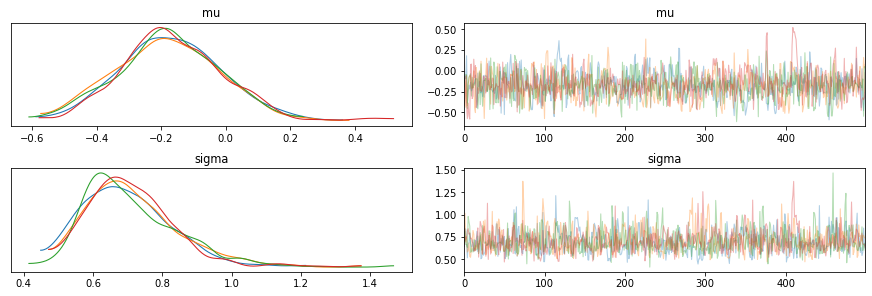

In [2]:
#実験用のシミュレーションデータ
N=20
Y=np.random.randn(N)
plt.title("histgram of input data")
plt.hist(Y)
plt.show()

#事前分布なし
print("========1st: Without prior")

#モデルパラメータ: prio=noneは事前分布なし、 prio=normalはnormal distribution事前分布 (stanコードに展開される)
param=[{"name":"mu","prio":"none","opt":""},
       {"name":"sigma","prio":"none","opt":"<lower=0>"},
       ]
d={"param":param}
model=get_stan_model("static",d)#stanを直接書くのはたるいので、テンプレートエンジンmakoを通してコード生成
print_code(model) #テンプレートを適用した後のstanコード、このコードをstanに突っ込んでいます
stan_data={
        "N":N,
        "Y":Y,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=4)

#以下は結果の出力
print(fit)
#サンプリング後のパラメータの分布出力
az.plot_trace(fit, var_names=("mu","sigma"))
plt.show()




## 事前分布あり(平均:mu,標準偏差:sigma)

========2nd: With prior for mu and sigma
1 
2 data{
3     int N;
4     vector[N] Y;
5 
6     real mu_u;
7     real mu_s;
8 
9     real sigma_u;
10     real sigma_s;
11 }
12 
13 parameters{
14     real mu;
15     real<lower=0> sigma;
16 }
17 model{
18     mu ~ normal(mu_u,mu_s);
19     sigma ~ normal(sigma_u,sigma_s);
20     Y ~ normal(mu,sigma);
21 }
22 
Inference for Stan model: static_393a401cd3865d5709b119a33f10040c.
4 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     -0.16  4.1e-3   0.16  -0.47  -0.27  -0.16  -0.06   0.16   1464    1.0
sigma    0.7  3.5e-3   0.12   0.52   0.61   0.68   0.77   0.98   1193    1.0
lp__   -2.56    0.03   0.97  -5.09  -2.91  -2.28  -1.88   -1.6    927    1.0

Samples were drawn using NUTS at Fri Aug 14 22:52:31 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the pote

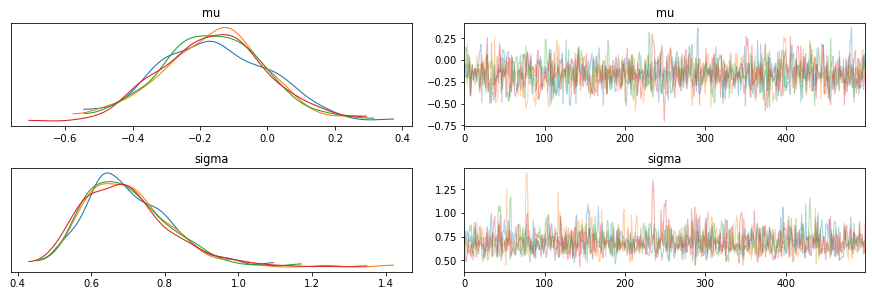

In [3]:
print("========2nd: With prior for mu and sigma")
param=[{"name":"mu","prio":"normal","opt":""},
       {"name":"sigma","prio":"normal","opt":"<lower=0>"},
       ]
d={"param":param}
model=get_stan_model("static",d)
print_code(model)

#事前分布のパラメータは「_u」平均値「_s」が標準偏差
stan_data={
        "N":N,
        "Y":Y,
        "mu_u":1, # 真値(0)に対してオフセットが掛かった事前分布だが推定には大きな影響を与えない
        "mu_s":3, # 十分に広い(=弱い)事前分布にしてある
        "sigma_u":0,
        "sigma_s":3,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=4)
print(fit)
az.plot_trace(fit, var_names=("mu","sigma"))
plt.show()

# 線形回帰の例
この程度ならば、事前分布の設定がなくても安定してサンプリングできる。（難しい事を考えたくないときは設定しなくてもよい。）


1 
2 functions{
3     vector func(int N,vector x,real a,real b,real sigma){
4         return a*x + b;
5     }
6 }
7 data{
8     int N;
9     vector[N] X;
10     vector[N] Y;
11 
12 
13 
14 }
15 
16 parameters{
17     real a;
18     real b;
19     real<lower=0> sigma;
20 }
21 transformed parameters{
22     vector[N] yy;
23     yy=func(N,X,a,b,sigma);
24 }
25 
26 model{
27     Y ~ normal(yy,sigma);
28 }
29 
Inference for Stan model: reg_9030348626bbec5dfb296edaa10e01fc.
8 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   1.05  1.2e-3   0.05   0.95   1.02   1.05   1.09   1.16   2131    1.0
a       2.14  6.7e-3   0.26   1.64   1.97   2.14   2.31   2.66   1494    1.0
b     4.5e-3  3.8e-3   0.15  -0.29  -0.09 1.1e-3    0.1   0.29   1539    1.0

Samples were drawn using NUTS at Fri Aug 14 22:52:36 2020.
For each parameter, n_eff is a crude measu

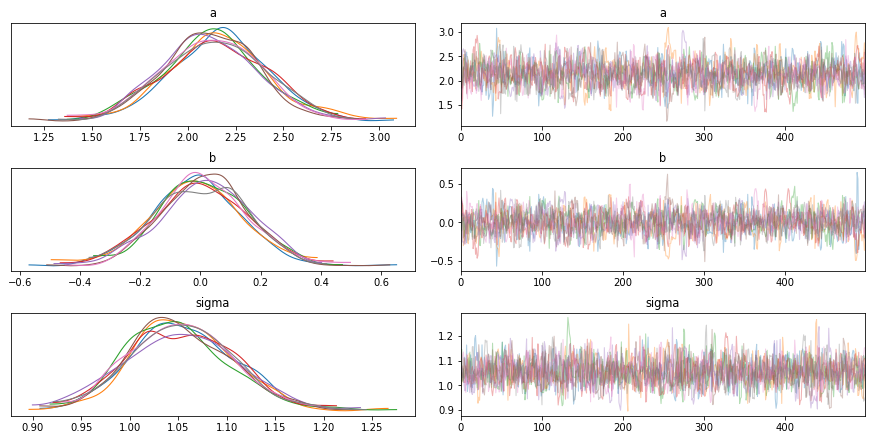

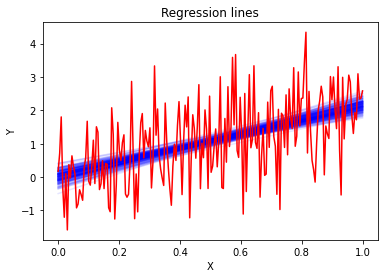

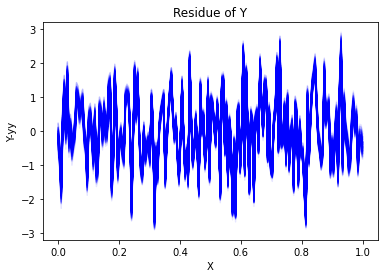

In [4]:
#Make simulation data
N=200
X=np.linspace(0,1,N)
Y=np.random.randn(N)*1 + X*2

#make model
param=[{"name":"a","prio":"none","opt":""},
       {"name":"b","prio":"none","opt":""},
       {"name":"sigma","prio":"none","opt":"<lower=0>"},
       ]
d={"param":param,"func":"return a*x + b;"} #ここでモデル関数ax+bを設定している (線形回帰)
model=get_stan_model("reg",d)
print_code(model)

#run stan code
stan_data={
        "N":N,
        "X":X,
        "Y":Y,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=8)

#visualize
print(fit.stansummary(pars=list(set(fit.model_pars)-set(["yy"]))))
az.plot_trace(fit, var_names=("a", "b","sigma"))
plt.show()
plot_rec(X,Y,fit)

# ガウス関数フィッティングの例

ガウス関数フィッティングをやってみます中心u=0、幅s=1、高さa=2、オフセットb=0、ノイズ高さsigma=1というパラメータを想定しています。

こんな簡単なものでも、事前分布なしでは安定にサンプリングできない。⇒つまり弱事前分布は必要！

1つ目は事前情報なし、２つめは広いガウス分布が事前分布

MCMCはどうしても局所解にトラップされる宿命にある。その局所解に落ちないように、パラメータの範囲は高々この程度と指定するのが弱事前分布。
理由有って「弱」ではないカッチリとした事前分布を使う事もあるが、計測装置の特性から求まる分布あったり、
階層モデル(そのうち説明）等を使いたくなったりした後だと思う。


## 事前分布なし

========1st: Without prior
1 
2 functions{
3     vector func(int N,vector x,real a,real b,real u,real s,real sigma){
4         vector[N] xx=(x-u)/s; return a*exp(-xx .* xx ) + b;
5     }
6 }
7 data{
8     int N;
9     vector[N] X;
10     vector[N] Y;
11 
12 
13 
14 
15 
16 }
17 
18 parameters{
19     real a;
20     real b;
21     real u;
22     real<lower=0,upper=1000> s;
23     real<lower=0> sigma;
24 }
25 transformed parameters{
26     vector[N] yy;
27     yy=func(N,X,a,b,u,s,sigma);
28 }
29 
30 model{
31     Y ~ normal(yy,sigma);
32 }
33 


Inference for Stan model: reg_27285fad7012e63ff2e41b392a754705.
8 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     4.0e10  6.2e10 1.4e11-9.2e10 -4.6e8  546.6  1.9e9 4.8e11      5   2.75
u    -8.9e10  1.3e11 6.2e11-1.8e12 -6.1e7   0.02  3.0e9 3.3e11     25   1.38
s     413.65   73.75 306.69  32.14  89.11 388.88  672.6 969.55     17   1.19
b     -100.7   90.27 213.75 -710.2   0.38   0.53    0.6   0.75      6   3.76
sigma   1.17    0.03   0.08   0.98   1.13   1.18   1.23   1.32     10   1.41

Samples were drawn using NUTS at Fri Aug 14 22:53:42 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


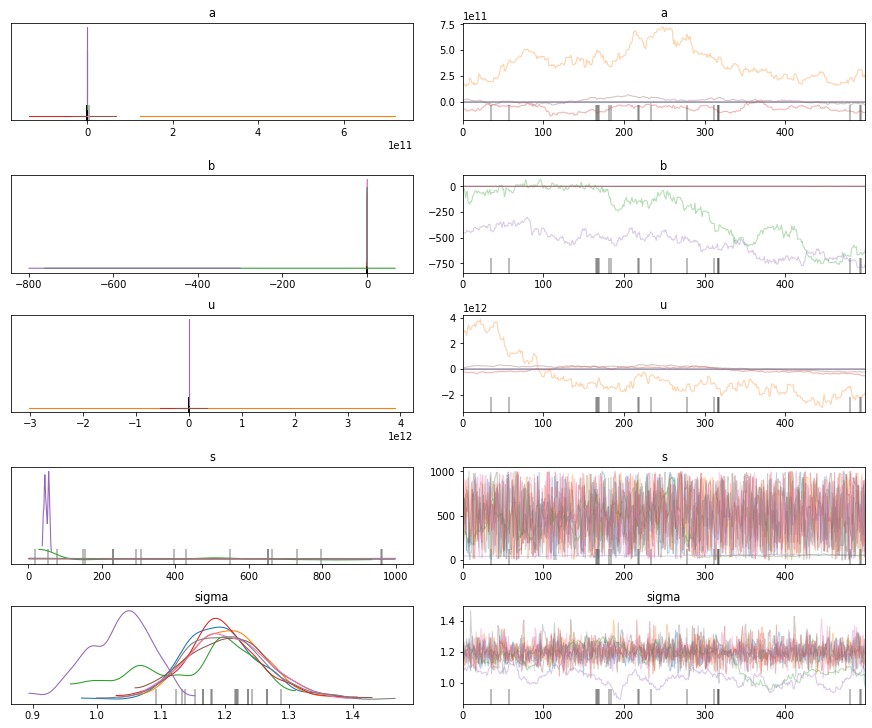

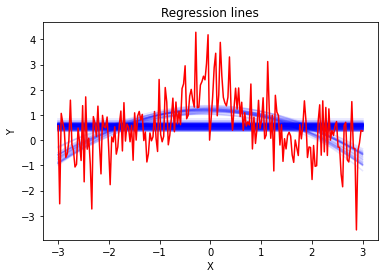

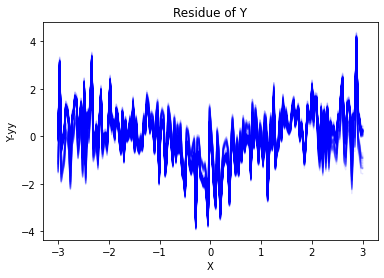

In [5]:
N=200
X=np.linspace(-3,3,N)
Y=np.random.randn(N)+ 2*np.exp(-X**2)

#make model
print("========1st: Without prior")
param=[{"name":"a","prio":"none","opt":""},
       {"name":"b","prio":"none","opt":""},
       {"name":"u","prio":"none","opt":""},
       {"name":"s","prio":"none","opt":"<lower=0,upper=1000>"}, #NaNよけのためにupper limitを設定している（アドホックな対処で、深い意味はない)
       {"name":"sigma","prio":"none","opt":"<lower=0>"},
       ]
d={"param":param,"func":"vector[N] xx=(x-u)/s; return a*exp(-xx .* xx ) + b;"} #回帰関数をガウス関数(exp(-x**2)として定義
model=get_stan_model("reg",d)
print_code(model)

#run stan code
stan_data={
        "N":N,
        "X":X,
        "Y":Y,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=8)

#visualize
print(fit.stansummary(pars=list(set(fit.model_pars)-set(["yy"]))))
az.plot_trace(fit, var_names=("a", "b","u","s","sigma"))
plt.show()
plot_rec(X,Y,fit)


## 事前分布あり(a：ピーク高さ,u:ピーク中心,s：ピーク幅)

In [ ]:
print("========2nd: With prior  a,u,s")
param=[{"name":"a","prio":"none","opt":""},
       {"name":"b","prio":"none","opt":""},
       {"name":"u","prio":"normal","opt":""},
       {"name":"s","prio":"normal","opt":"<lower=0>"},
       {"name":"sigma","prio":"none","opt":"<lower=0>"},
       ]
d={"param":param,"func":"vector[N] xx=(x-u)/s; return a*exp(-xx .* xx ) + b;"}
model=get_stan_model("reg",d)
print_code(model)

#run stan code
stan_data={
        "N":N,
        "X":X,
        "Y":Y,
        "a_u":3,
        "a_s":3,
        "u_u":1, # conatins offset error 
        "u_s":3,
        "s_u":0, #contains offset error
        "s_s":10,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=4)

#visualize
print(fit.stansummary(pars=list(set(fit.model_pars)-set(["yy"]))))
az.plot_trace(fit, var_names=("a", "b","u","s","sigma"))
plt.show()
plot_rec(X,Y,fit)

# 以下は説明用の図作成なので気にしないで

1 
2 functions{
3     vector func(int N,vector x,real a,real b,real sigma){
4         return a*x + b;
5     }
6 }
7 data{
8     int N;
9     vector[N] X;
10     vector[N] Y;
11 
12 
13 
14 }
15 
16 parameters{
17     real a;
18     real b;
19     real<lower=0> sigma;
20 }
21 transformed parameters{
22     vector[N] yy;
23     yy=func(N,X,a,b,sigma);
24 }
25 
26 model{
27     Y ~ normal(yy,sigma);
28 }
29 
Inference for Stan model: reg_9030348626bbec5dfb296edaa10e01fc.
4 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   0.89    0.02   0.36   0.48   0.66   0.81   1.02   1.79    470   1.01
a       2.48    0.04   1.03   0.45   1.89   2.53   3.09   4.46    634    1.0
b       0.42    0.02   0.61  -0.73   0.06   0.39   0.76    1.7    651    1.0

Samples were drawn using NUTS at Fri Aug 14 22:55:14 2020.
For each parameter, n_eff is a crude measu

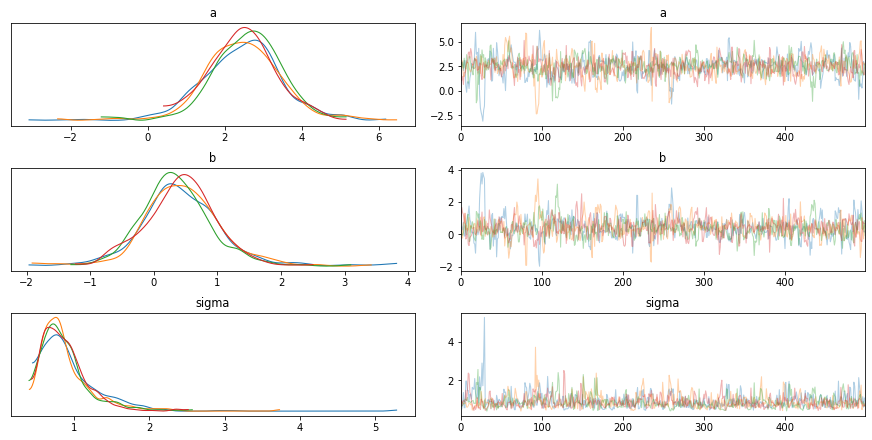

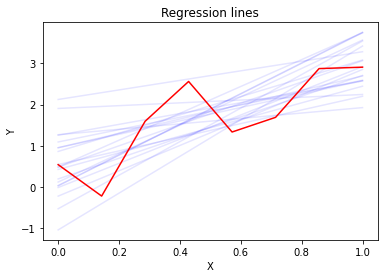

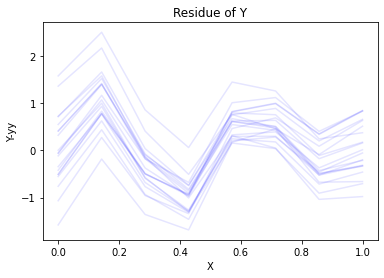

In [8]:
#Make simulation data
N=8
X=np.linspace(0,1,N)
Y=np.random.randn(N)*1 + X*2

#make model
param=[{"name":"a","prio":"none","opt":""},
       {"name":"b","prio":"none","opt":""},
       {"name":"sigma","prio":"none","opt":"<lower=0>"},
       ]
d={"param":param,"func":"return a*x + b;"} #ここでモデル関数ax+bを設定している (線形回帰)
model=get_stan_model("reg",d)
print_code(model)

#run stan code
stan_data={
        "N":N,
        "X":X,
        "Y":Y,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=4)

#visualize
print(fit.stansummary(pars=list(set(fit.model_pars)-set(["yy"]))))
az.pls
plt.show()
plot_rec(X,Y,fit,NOF_PLOT=20)